In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nitishpandey04","key":"25e697bcb9f519cb2af5d5a7c19f2874"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:03<00:00, 242MB/s]
100% 812M/812M [00:03<00:00, 237MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

In [8]:
import os, shutil, pathlib

In [9]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [10]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### We will train the model with EarlyStopping callback along with ModelCheckpoint and we do data augmentation. 

In [20]:
data_augmentation = keras.Sequential([
                                      layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)
], name="data_augmentation")

In [21]:
callbacks = [
            #  keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
             keras.callbacks.ModelCheckpoint(
                 filepath="regularized_covnet_from_scratch.keras",
                 save_best_only=True,
                 monitor="val_loss"
             )
]

## Mini Xception Model
1. model organized in repeated blocks of layers - modularity-hierarchy-reuse (MHR) formula
2. number of filters increase as the size of spatial feature maps increase
3. deep and narrow is better than broad and shallow
4. residual connections around blocks of layers helps you train deeper network
5. batch normalization after every layer can be beneficial for gradient propagation
6. replacing Conv2D with SeparableConv2D reduces the number of parameters to train, making it faster and less prone to overfitting

In [22]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255) (x)
x = layers.Conv2D(32, kernel_size=5, use_bias=False) (x)
for size in [32, 64, 128, 256, 512]:
    residual = x
    x = layers.BatchNormalization() (x)
    x = layers.Activation("relu") (x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False) (x)
    x = layers.BatchNormalization() (x)
    x = layers.Activation("relu") (x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False) (x)
    x = layers.MaxPooling2D(3, strides=2, padding="same") (x)
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False) (residual)
    x = layers.add([x, residual])
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(1, activation="sigmoid") (x)
model = keras.Model(inputs, outputs)

In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 180, 180, 3)  0          ['input_5[0][0]']                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 180, 180, 3)  0           ['data_augmentation[0][0]']      
                                                                                                  
 conv2d_14 (Conv2D)             (None, 176, 176, 32  2400        ['rescaling_4[0][0]']      

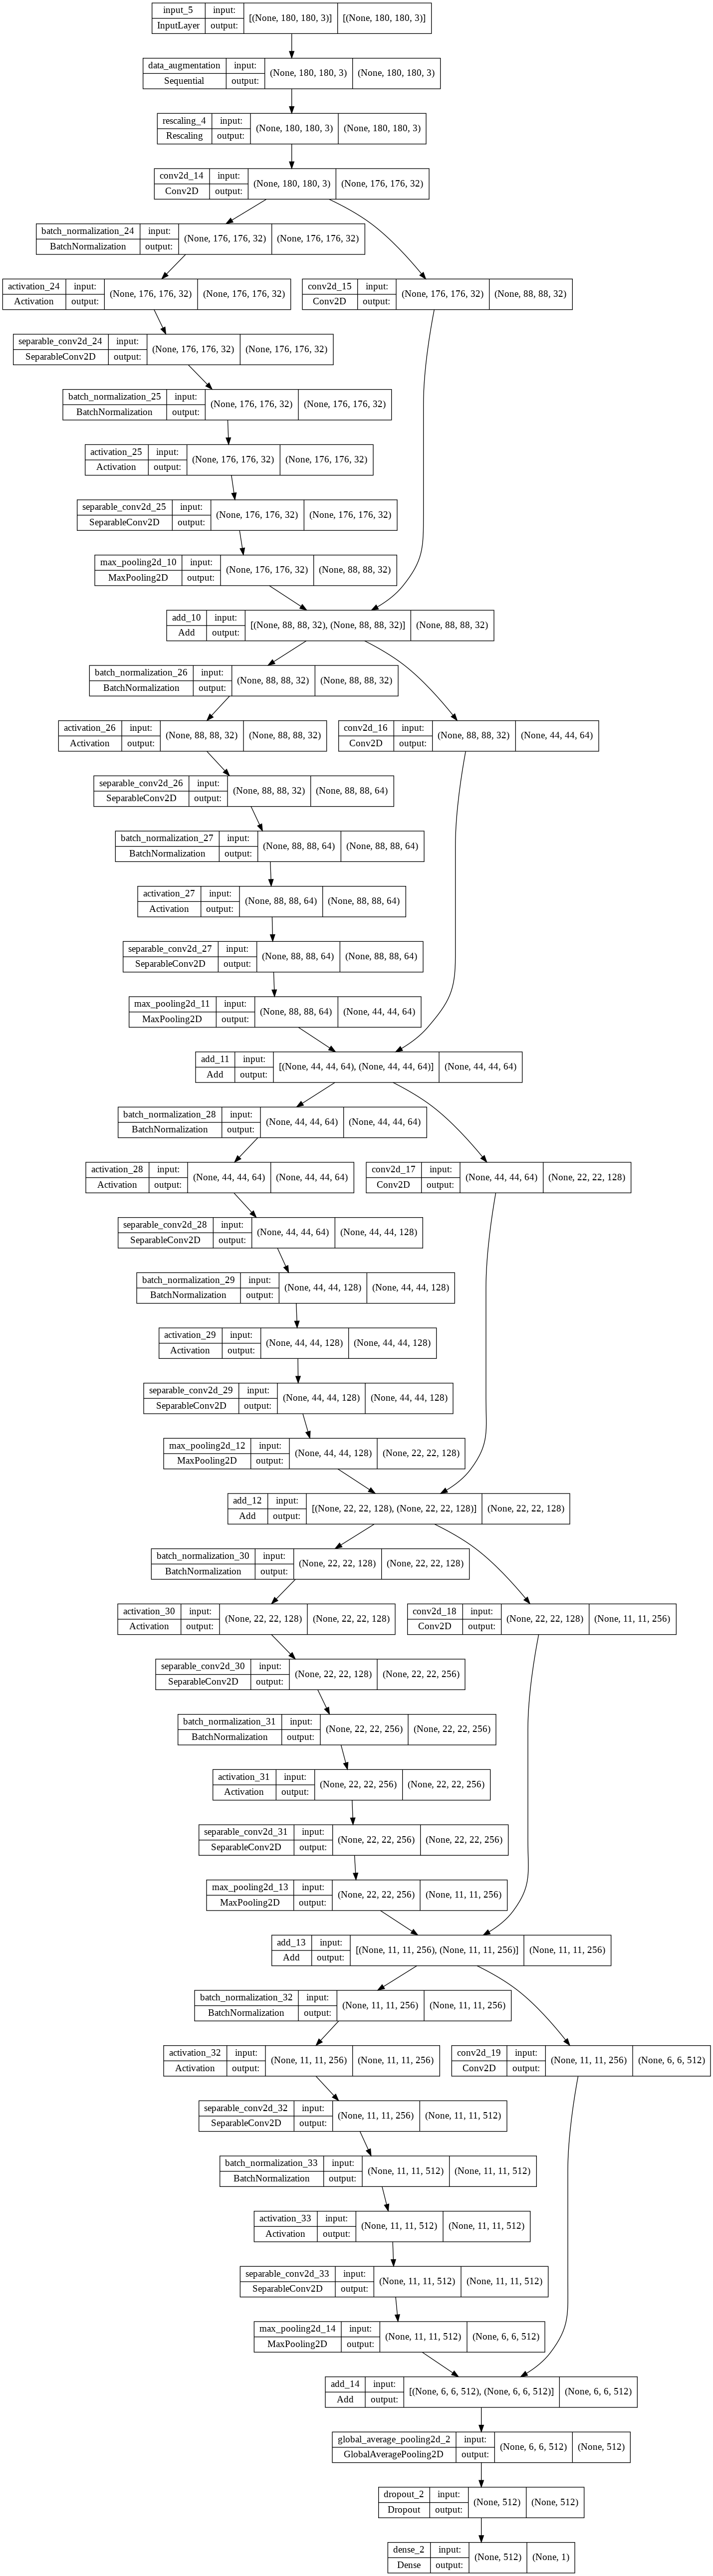

In [25]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

In [ ]:
saved_model = keras.models.load_model("modern_covnet_architecture.keras")

In [ ]:
saved_model.evaluate(test_dataset)